In [1]:
%pylab inline
import numpy as np
import pylab as pl
import wradlib as wrl
import os
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [31]:
def read_JBirds(datapath,fname):
    f = open(os.path.join(datapath,fname), 'rb')
    r = np.fromfile(f, dtype='B')
    f.close()

    # Raw Data Header
    #   ignore first 96 members
    raw_data_header = r[96:352]
    # Sweep Data
    data = np.reshape(r[352:],(360,352))

    # Sweep Header
    sweep_header = data[:,:32]
    sweep_data = data[:,32:] * 0.3125 # 0.3125dBZ per member value

    # collect attributes from header
    attrs = {}

    # location
    loc = raw_data_header[1]
    if loc == int('40',16):
        attrs['Location'] = 'Virac'
        attrs['sitecoords'] = (13.6298, 124.3338, 0)
        attrs['Latitude'] = 13.6298
        attrs['Longitude'] = 124.3338
    elif loc == int('41',16):
        attrs['Location'] = 'Aparri'
        attrs['sitecoords'] = (18.35, 121.64, 0)
        attrs['Latitude'] = 18.35
        attrs['Longitude'] = 121.64
    elif loc == int('42',16):
        attrs['Location'] = 'Guiuan' #11.045095, 125.755896
        attrs['sitecoords'] = (11.0451, 125.7559, 15)
        attrs['Latitude'] = 11.0451
        attrs['Longitude'] = 125.7559
    else:
        attrs['Location'] = 'other'
    # Data type
    dattype = raw_data_header[3]
    if dattype == int('75',16):
        attrs['Data Type'] = 'Doppler Velocity'
    elif dattype == int('76',16):
        attrs['Data Type'] = 'Spectrum Width'
    elif dattype == int('F1',16):
        attrs['Data Type'] = 'Reflectivity'
    else:
        attrs['Data Type'] = 'other'
    # Date Time
    datestr = ''.join([chr(f) for f in raw_data_header[8:24]])
    attrs['time'] = dt.datetime.strptime(datestr, '%Y.%m.%d.%H.%M')
    # Response Status
    if raw_data_header[29] == 0:
        attrs['Response Status'] = 'Normal'
    else:
        attrs['Response Status'] = 'Error'
    # Step no.
    attrs['Step number'] = raw_data_header[42]
    ## Elevation
    #attrs['Elevation'] = raw_data_header[44]*360./(2**16)
    # Z-Relation-B
    attrs['Z-Relation B'] = raw_data_header[52]/100.
    # Z-Relation-Beta
    attrs['Z-Relation Beta'] = raw_data_header[54]/100.

    # get attributes from filename
    elev = int(fname[::-1][18:22][::-1])
    if fname[::-1][16:18][::-1] == 'P1':
        attrs['Elevation'] = elev / 10.
    elif fname[::-1][16:18][::-1] == 'P2':
        attrs['Elevation'] = elev / 100.
    attrs['Sweep'] = int(fname[::-1][13:15][::-1])

    attrs['MissingData'] = 255 * 0.3125
    if int(attrs['Sweep']) > 3:
        attrs['r'] = np.linspace(625,200000,320)
    else:
        attrs['r'] = np.linspace(1375,441375,320)
    attrs['az'] = np.linspace(1,360,360)

    data = np.where(sweep_data==attrs['MissingData'], np.nan, sweep_data)

    return data, attrs

In [32]:
fpath = "../phirad-data/radars/guiuan"

In [33]:
fnames = os.listdir(fpath)

In [34]:
# Read shapefile for overlay
PATH_Ph_shapefile = '../phirad-data/shapefiles/Country/Country.shp'
dataset, inLayer = wrl.io.open_shape(PATH_Ph_shapefile)
borders, keys = wrl.georef.get_shape_coordinates(inLayer)

proj = wrl.georef.epsg_to_osr(4326)

In [35]:
data, attrs = read_JBirds(fpath,fnames[4])

In [36]:
sitecoords = attrs['sitecoords'][1], attrs['sitecoords'][0]
print sitecoords

(125.7559, 11.0451)


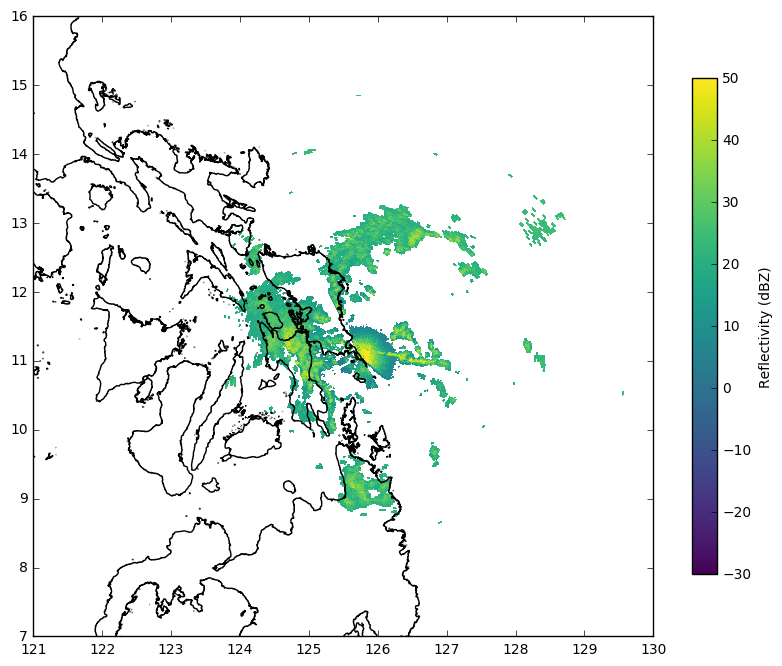

In [37]:
fig = pl.figure(figsize=(10, 8))
ax,pm = wrl.vis.plot_ppi(np.ma.masked_invalid(data), attrs['r'], 
                         az=np.arange(0,360), site=sitecoords, proj=proj, vmax=50, vmin=-30,
                         cmap=pl.cm.viridis)
wrl.vis.add_lines(ax, borders, color='black', lw=1.)
cb = pl.colorbar(pm, shrink=0.8)
cb.set_label('Reflectivity (dBZ)')

In [38]:
attrs['time']

datetime.datetime(2017, 1, 9, 4, 0)

In [39]:
data, attrs = read_JBirds(fpath,fnames[7])

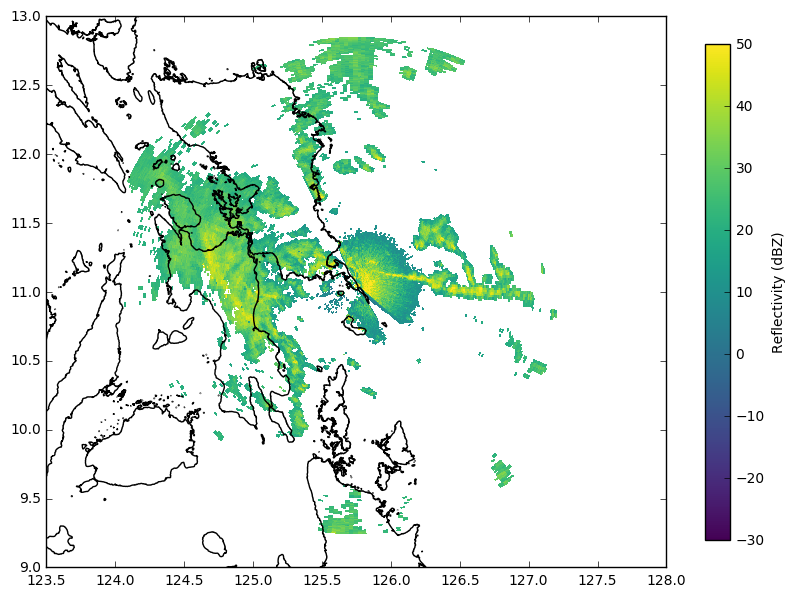

In [40]:
fig = pl.figure(figsize=(10, 8))
ax,pm = wrl.vis.plot_ppi(np.ma.masked_invalid(data), attrs['r'], 
                         az=np.arange(0,360), site=sitecoords, proj=proj, vmax=50, vmin=-30,
                         cmap=pl.cm.viridis)
wrl.vis.add_lines(ax, borders, color='black', lw=1.)
cb = pl.colorbar(pm, shrink=0.8)
cb.set_label('Reflectivity (dBZ)')

In [26]:
attrs['Elevation']

0.0

In [30]:
fname = fnames[3]
fname[::-1][13:15][::-1]

'04'